# DATA REFORMATTER
Notebook que contiene el proceso realizado para la extracción, modificación y guardado de los datos relacionados con los alquileres, devoluciones, estaciones y datos meteorológicos.

## LIBRERÍAS

In [2]:
import pandas as pd
import numpy as np
import os
import urllib.request, json

from datetime import datetime, timedelta
from sklearn import preprocessing

## FORMATEO DE LOS DATOS DE TRAYECTOS
Se parte de unos cuantos CSVs, que contienen los datos que representan los diferentes trayectos que se han realizado en el sistema de Capital Bikeshare. Estos han sido descargados desde la [página oficial](https://s3.amazonaws.com/capitalbikeshare-data/index.html), donde a día de hoy se publican mensualmente los datos que ha recopilado el sistema. Estos datos han sido previamente procesados, es decir, se han eliminado los viajes de menos de 1 minuto (falsos comienzos) y los realizados por los técnicos en las estaciones de prueba. Si observamos estos datos, podemos darnos cuenta de que no todos siguen el mismo formato y almacenan ciertos atributos que no son relevantes para este estudio.

Diferencias en los años:
* 2010 y 2011 contienen todos los datos en un solo fichero y 2010 comienza desde  el día 20/09.
* 2012 - 2017 los datos se separan en cuatro trimestres --> [Q1, Q2, Q3 Y Q4].
* 2018 - 2022 los datos se separan por meses.
* A partir de 2020 se añadieron y renombraron atributos.

In [15]:
def getYearDf(year):
    """
    Generate an anual dataframe from Capital Bikeshare data
    Arguments:
        year: an integer
    Returns:
        Anual dataframe of selected year trips.
    """

    dfYear = pd.DataFrame()

    # 2010-2011
    if year in range(2010, 2012):
        df = pd.read_csv("../data/tripdata/downloaded/" + str(year) + "-capitalbikeshare-tripdata/" + str(year) + "-capitalbikeshare-tripdata.csv")
        df.drop(columns=['Duration', 'Bike number', 'Member type'], inplace=True)
        df['Start date'] = pd.to_datetime(df['Start date'])
        return df
    
    # 2012-2017
    elif year in range(2012, 2018):
        for trimester in range(1,5):
            df = pd.read_csv("../data/tripdata/downloaded/" + str(year) +"-capitalbikeshare-tripdata/" + str(year) + "Q" + str(trimester) +"-capitalbikeshare-tripdata.csv")
            df.drop(columns=['Duration', 'Bike number', 'Member type'], inplace=True)
            df['Start date'] = pd.to_datetime(df['Start date'])
            dfYear = dfYear.append(df, ignore_index = True)
        return dfYear
    
    # 2018-2019
    elif year in range(2018, 2020):
        for month in range(1, 13):
            if month < 10: month = '0'+ str(month)
            
            try:
                df = pd.read_csv("../data/tripdata/downloaded/" + str(year) + str(month) +"-capitalbikeshare-tripdata/" + str(year) + str(month) +"-capitalbikeshare-tripdata.csv")
            except:
                #Caso en el que el fichero 01-2018 esta con '_' en vez de '-'
                df = pd.read_csv("../data/tripdata/downloaded/" + str(year) + str(month) +"-capitalbikeshare-tripdata/" + str(year) + str(month) +"_capitalbikeshare_tripdata.csv")
            
            df.drop(columns=['Duration', 'Bike number', 'Member type'], inplace=True)
            df['Start date'] = pd.to_datetime(df['Start date'])
            dfYear = dfYear.append(df, ignore_index=True)
        return dfYear
    
    # 2020-2021
    elif year >= 2020:
        for month in range(1, 13):
            if month < 10: month = '0'+ str(month)
            try:
                df = pd.read_csv("../data/tripdata/downloaded/" + str(year) + str(month) +"-capitalbikeshare-tripdata/" + str(year) + str(month) +"-capitalbikeshare-tripdata.csv")
            except:
                break # Puede no existir información de todos los meses del ultimo año
            
            try:
                df.drop(columns=['ride_id', 'rideable_type', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual'], inplace=True)
                df.rename(columns={"started_at": "Start date", 
                                   "ended_at": "End date",
                                   "start_station_name":"Start station",
                                   "start_station_id": "Start station number",
                                   "end_station_name":"End station",
                                   "end_station_id": "End station number"},
                          inplace=True)
            except:
                df.drop(columns=['Duration', 'Bike number', 'Member type'], inplace=True)
            finally:
                df = df.dropna(subset=['Start station', 'End station'], how='all')
                df['Start date'] = pd.to_datetime(df['Start date'])
                dfYear = dfYear.append(df, ignore_index=True)
                dfYear = dfYear.fillna({"Start station number": 0, "End station number": 0})
                dfYear = dfYear[dfYear['Start station number'] != 'MTL-ECO5-03']
        return dfYear.astype({"Start station number": int, "End station number": int})

In [16]:
def splitDfInDays(df, initDate, endDate):
    """
    Split a Dataframe into daily CSV data
    Arguments:
        df: dataframe to split
        initDate: first day of the split
        endDate: last day of the split
    Returns:
        Generates daily CSV data into tripData/transformed/
    """
    for day in np.arange(initDate, endDate, timedelta(days=1)).astype(datetime):
        nextDay = day + timedelta(days=1)
        dfSplitedDay = df[(df['Start date'] >= day) & (df['Start date'] < nextDay)]
        if len(dfSplitedDay.index) > 0:
            try:
                dfSplitedDay.to_csv(os.path.join('../data/tripdata/transformed/' + str(initDate.year) +  '/' + str(day.date()) + '.csv'), index=False)
            except:
                if not os.path.exists('../data/tripdata/transformed/'):
                    os.mkdir('../data/tripdata/transformed/')
                if not os.path.exists('../data/tripdata/transformed/' + str(initDate.year)):
                    os.mkdir('../data/tripdata/transformed/' + str(initDate.year))
            dfSplitedDay.to_csv(os.path.join('../data/tripdata/transformed/' + str(initDate.year) +  '/' + str(day.date()) + '.csv'), index=False)

In [17]:
def dataReformatter(startYear, endYear):
    """
    Give the correct format to the data retrieved from Capital Bikeshare
    Arguments:
        startYear: first year of the reformatting
        endYear: last year of the reformatting
    Returns:
        Generates reformatted daily CSV data into tripData/transformed/
    """
    for year in range(startYear, endYear+1):
        df = getYearDf(year)
        initDate, endDate = datetime(year,1,1), datetime(year+1,1,1)
        splitDfInDays(df, initDate, endDate)
        print("Año {} formateado con exito!".format(year))

Con las funciones anteriores creadas, podemos proceder a formatear todo el conjunto de datos descargados. Se generarán CSVs por cada día, conteniendo todos los mismos atributos.

In [18]:
dataReformatter(2010, 2022)

Año 2010 formateado con exito!
Año 2011 formateado con exito!
Año 2012 formateado con exito!
Año 2013 formateado con exito!
Año 2014 formateado con exito!
Año 2015 formateado con exito!
Año 2016 formateado con exito!
Año 2017 formateado con exito!
Año 2018 formateado con exito!
Año 2019 formateado con exito!
Año 2020 formateado con exito!


C:\Users\User\AppData\Local\Temp\ipykernel_22976\4003686355.py:11: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  df = getYearDf(year)


Año 2021 formateado con exito!
Año 2022 formateado con exito!


## RECOPILACION DEL DATASET DE TRAYECTOS FORMATEADO
Para facilitar el manejo de los datos, se recopilará el conjunto de CSVs con los datos diarios en un único CSV.

In [27]:
def getCompleteDf(initDate, endDate):
    """
    Collect daily trip data into unique CSV.
    Arguments:
        initDate: date to start collecting data
        endDate: date to end collecting data
    Returns:
        Returns Dataframe containing the daily data collected.
    """
    completeDf = pd.DataFrame()
    for i,day in enumerate(np.arange(initDate, endDate, timedelta(days=1)).astype(datetime)):
        if i!= 0 and i%365==0: print("Año {} agregado con exito!". format(day.year-1))
        try:
            df = pd.read_csv("../data/tripdata/transformed/" + str(day.year) +"/" + str(day.date()) +".csv")
            df = df.sort_values(["Start date", "End date"])
            completeDf = completeDf.append(df, ignore_index = True)
        except:
            print("No existe el dia {}".format(day)) # Casos que no existen como 23-26/01/2016
    return completeDf

In [28]:
initDate = datetime(2010,9,20)
endDate = datetime(2022,4,1)
completeDf = getCompleteDf(initDate, endDate)

Año 2010 agregado con exito!
Año 2011 agregado con exito!
Año 2012 agregado con exito!
Año 2013 agregado con exito!
Año 2014 agregado con exito!
No existe el dia 2016-01-23 00:00:00
No existe el dia 2016-01-24 00:00:00
No existe el dia 2016-01-25 00:00:00
No existe el dia 2016-01-26 00:00:00
Año 2015 agregado con exito!
Año 2016 agregado con exito!
Año 2017 agregado con exito!
Año 2018 agregado con exito!
Año 2019 agregado con exito!
Año 2020 agregado con exito!


Se visualiza el comienzo y el final del Dataframe completo, comprobando que las fechas coinciden con el rango seleccionado en la función anterior.

In [35]:
print("El conjunto de datos sobre alquileres de bicias tiene {} filas/trayectos y {} columnas".format(completeDf.shape[0], completeDf.shape[1]))
completeDf.head(5)

El conjunto de datos sobre alquileres de bicias tiene 31358265 filas/trayectos y 6 columnas


,Start date,End date,Start station number,Start station,End station number,End station
0,2010-09-20 11:27:04,2010-09-20 11:43:56,31208,M St & New Jersey Ave SE,31108,4th & M St SW
1,2010-09-20 11:41:22,2010-09-20 11:42:23,31209,1st & N St SE,31209,1st & N St SE
2,2010-09-20 12:05:37,2010-09-20 12:50:27,31600,5th & K St NW,31100,19th St & Pennsylvania Ave NW
3,2010-09-20 12:06:05,2010-09-20 12:29:32,31600,5th & K St NW,31602,Park Rd & Holmead Pl NW
4,2010-09-20 12:10:43,2010-09-20 12:34:17,31100,19th St & Pennsylvania Ave NW,31201,15th & P St NW


In [36]:
completeDf.tail(5)

,Start date,End date,Start station number,Start station,End station number,End station
31358260,2022-03-31 23:57:02,2022-04-01 00:29:14,31202,14th & R St NW,31654,King Greenleaf Rec Center
31358261,2022-03-31 23:57:03,2022-04-01 00:00:12,31105,14th & Harvard St NW,31401,14th St & Spring Rd NW
31358262,2022-03-31 23:57:08,2022-04-01 00:09:45,31202,14th & R St NW,31527,North Capitol & R St NE
31358263,2022-03-31 23:58:13,2022-04-01 00:26:31,31230,Metro Center / 12th & G St NW,31260,23rd & E St NW
31358264,2022-03-31 23:58:55,2022-04-01 00:01:40,31328,21st St & G st NW,31275,New Hampshire Ave & 24th St NW


### GUARDADO DEL DATASET COMPLETO

In [31]:
completeDf.to_csv('../data/completeData/completeDf.csv', index=False)

### CARGA DEL DATASET COMPLETO

In [34]:
df = pd.read_csv('../data/completeData/completeDf.csv')

## COMPROBACIÓN Y CREACIÓN DEL CONJUNTO DE ESTACIONES
La siguiente imagen obtenida de la página de Capital Bikeshare, muestra en un mapa las diferentes estaciones y bicicletas sueltas que existen en el sistema, referentes a un instante de tiempo específico. Podemos observar que se abarca un gran área de Washington DC y alrededores.

<img src="stations.png">

### COMPROBACION DE LAS ESTACIONES EXISTENTES EN EL CONJUNTO DE DATOS
Por un lado, se comprobará cuáles son las estaciones en las que se ha iniciado algún trayecto.

In [211]:
dfStationsStart = df[["Start station number", "Start station"]]
dfStationsStart = dfStationsStart.drop_duplicates(subset =["Start station number"], keep = "last")
dfStationsStart = dfStationsStart.sort_values(["Start station number", "Start station"])
print("Existen {} estaciones en las que se han iniciado trayectos".format(dfStationsStart.shape[0]))

Existen 697 estaciones en las que se han iniciado trayectos


Por otro lado, se comprueba en cuáles se han finalizado algún trayecto.

In [212]:
dfStationsEnd = df[["End station number", "End station"]]
dfStationsEnd = dfStationsEnd.drop_duplicates(subset =["End station number"], keep = "last")
dfStationsEnd = dfStationsEnd.sort_values(["End station number", "End station"])
print("Existen {} estaciones en las que se han finalizado trayectos".format(dfStationsEnd.shape[0]))

Existen 698 estaciones en las que se han finalizado trayectos


Se mezclan los dos conjuntos de estaciones y se crea uno único.

In [213]:
dfStationsEnd.rename(columns={"End station number": "Start station number", "End station": "Start station"}, inplace=True)
dfStationsStart = dfStationsStart.append(dfStationsEnd)
dfStations = pd.DataFrame()
dfStations = dfStationsStart.drop_duplicates(subset =["Start station number", "Start station"], keep = "last")
dfStations = dfStations.rename(columns={"Start station number": "Station ID", "Start station": "Name"})
dfStations = dfStations.set_index('Station ID')
print("Existen {} estaciones finales".format(dfStations.shape[0]))

Existen 698 estaciones finales


### AÑADIR INFORMACIÓN DEL GBFS AL DATAFRAME DE ESTACIONES
Existen APIs que ofrecen la información en tiempo real de diferentes características de un sistema de bicicletas compartidas. En este vamos a obtener la información que se ofrece de las diferentes estaciones del sistema y se agregara a la información de las estaciones.

In [214]:
url = "https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json"
response = urllib.request.urlopen(url)
stationsInfoJson = json.loads(response.read())
stationsInfoJson = stationsInfoJson['data']['stations']
dfStations["GBFS Name"], dfStations["Capacity"], dfStations["Lon"], dfStations["Lat"]  = np.nan, 0, 0, 0

for i in range(0, len(stationsInfoJson)):
    try:
        dfStations.loc[int(stationsInfoJson[i]['short_name']), 'GBFS Name'] = stationsInfoJson[i]['name']
        dfStations.loc[int(stationsInfoJson[i]['short_name']), 'Capacity'] = stationsInfoJson[i]['capacity']
        dfStations.loc[int(stationsInfoJson[i]['short_name']), 'Lon'] = stationsInfoJson[i]['lon']
        dfStations.loc[int(stationsInfoJson[i]['short_name']), 'Lat'] = stationsInfoJson[i]['lat']
    except:
        print("No existe la estacion Nº {}".format(stationsInfoJson[i]['short_name']))

In [215]:
dfStations.head(5)

,Name,GBFS Name,Capacity,Lon,Lat
Station ID,,,,,
0,NaN,NaN,0,0.000000,0.000000
31000,Eads St & 15th St S,Eads St & 15th St S,15,-77.053230,38.858971
31001,18th St & S Eads St,NaN,0,0.000000,0.000000
31002,Crystal Dr & 20th St S,Crystal Dr & 20th St S,17,-77.049232,38.856425
31003,Crystal Dr & 15th St S,Crystal Dr & 15th St S,16,-77.049417,38.861056


In [216]:
dfStations.tail(5)

,Name,GBFS Name,Capacity,Lon,Lat
Station ID,,,,,
32609,W Columbia St & N Washington St,W Columbia St & N Washington St,12,-77.166917,38.885621
32900,Motivate BX Tech office,NaN,0,0.000000,0.000000
32901,6035 Warehouse,NaN,0,0.000000,0.000000
32902,Motivate Tech Office,NaN,0,0.000000,0.000000
32906,V1 Warehouse Test Station,NaN,0,0.000000,0.000000


Tras comprobar el conjunto entero de estaciones, se opta por borrar las cuatro últimas, que parecen ser estaciones de prueba usadas por los técnicos.

In [217]:
invalidStationsId = [32900, 32901, 32902, 32906]
for id in invalidStationsId: dfStations = dfStations.drop(id)

Se desconoce la razón por la que algunas estaciones existen en el histórico de datos de alquileres, pero no en el GBFS.

### GUARDADO DEL DATASET DE ESTACIONES

In [218]:
dfStations.to_csv("../data/completeData/stations.csv")

## CAMBIO DE FORMATO A ALQUILERES Y DEVOLUCIONES POR ESTACION
El objetivo del proyecto es predecir la oferta y la demanda que va a existir en cada una de las estaciones, por lo que es necesario transformar los datos de trayectos en dos conjuntos de alquileres y devoluciones por estación y hora.

In [226]:
def convertDailyDataToRentalsAndReturns(initDate, endDate, timeStep):
    """
    Generate daily CSV data containing rentals and returns.
    Arguments:
        initDate: date to start generating data
        endDate: date to end generating data
    Returns:
        Creates a collection of CSVs located in tripdata/transformed/ containing rentals and returns data for each station.
    """
    stations = pd.read_csv('../data/completeData/stations.csv')
    columnsNames = np.append("Date", stations['Station ID'].unique())
    dfMisplacedReturns = pd.DataFrame()  # Aqui se almacenaran temporalmente las devoluciones que estan fuera del intervalo de tiempo

    for i,day in enumerate(np.arange(initDate, endDate, timedelta(days=1)).astype(datetime)):
        if i!= 0 and i%365==0: print("Año {} transformado con exito!". format(day.year-1))
        nextDay = day + timedelta(days=1)
        dfRentals = dfReturns = pd.DataFrame(columns= columnsNames)
        try:
            df = pd.read_csv("../data/tripdata/transformed/" + str(day.year) +"/" + str(day.date()) +".csv")
            df['Start date'] = pd.to_datetime(df['Start date'])
            df['End date'] = pd.to_datetime(df['End date'])
        except:
            # Casos que no existen como 23-26/01/2016 se rellenan con 0s
            print("No existe el dia {}".format(day))
            emptyDayDf = pd.DataFrame(columns = columnsNames)
            for j,step in enumerate(np.arange(day.date(), nextDay, timeStep).astype(datetime)):
                dfzeros = pd.DataFrame([[0]*len(columnsNames)],columns=columnsNames)
                emptyDayDf = emptyDayDf.append(dfzeros, ignore_index=True)
                emptyDayDf["Date"][j] = str(step)
            emptyDayDf.to_csv('../data/tripdata/transformed/' + str(day.date().year) + '/RENTALS-' + str(day.date()) + '.csv', index=False)
            emptyDayDf.to_csv('../data/tripdata/transformed/' + str(day.date().year) + '/RETURNS-' + str(day.date()) + '.csv', index=False)
            continue

        if len(dfMisplacedReturns)> 0:
            df = df.append(dfMisplacedReturns)
            dfMisplacedReturns = pd.DataFrame()
        dfMisplacedReturns = df[df['End date'] > nextDay]

        for j,step in enumerate(np.arange(day.date(), nextDay, timeStep).astype(datetime)):

            nextStep = step + timeStep
            dfSplitedStepStart = df[(df['Start date'] >= step) & (df['Start date'] < nextStep)]
            dfSplitedStepEnd = df[(df['End date'] >= step) & (df['End date'] < nextStep)]

            dfzeros = pd.DataFrame([[0]*len(columnsNames)],columns=columnsNames)
            dfRentals = dfRentals.append(dfzeros, ignore_index=True)
            dfReturns = dfReturns.append(dfzeros, ignore_index=True)

            dfRentals["Date"][j], dfReturns["Date"][j] = str(step), str(step)

            rentals = dfSplitedStepStart['Start station number'].value_counts()
            returns = dfSplitedStepEnd['End station number'].value_counts()

            if len(rentals.index) > 0:
                for index, value in rentals.items():
                    try:
                        dfRentals[str(index)][j] += value
                    except:
                        print("No existe el indice {} en dfRentals".format(index))

            if len(returns.index) > 0:
                for index, value in returns.items():
                    try:
                        dfReturns[str(index)][j] += value
                    except:
                        print("No existe el indice {} en dfReturns".format(index))

        dfRentals.to_csv('../data/tripdata/transformed/' + str(day.date().year) + '/RENTALS-' + str(day.date()) + '.csv', index=False)
        dfReturns.to_csv('../data/tripdata/transformed/' + str(day.date().year) + '/RETURNS-' + str(day.date()) + '.csv', index=False)

In [227]:
initDate, endDate = datetime(2010,9,20), datetime(2022,4,1)
timeStep = timedelta(minutes=60)
convertDailyDataToRentalsAndReturns(initDate, endDate, timeStep)

Año 2010 transformado con exito!
Año 2011 transformado con exito!
Año 2012 transformado con exito!
Año 2013 transformado con exito!
Año 2014 transformado con exito!
No existe el dia 2016-01-23 00:00:00
No existe el dia 2016-01-24 00:00:00
No existe el dia 2016-01-25 00:00:00
No existe el dia 2016-01-26 00:00:00
Año 2015 transformado con exito!
Año 2016 transformado con exito!
Año 2017 transformado con exito!
Año 2018 transformado con exito!
No existe el indice 32901 en dfReturns
No existe el indice 32901 en dfReturns
No existe el indice 32901 en dfReturns
No existe el indice 32901 en dfReturns
No existe el indice 32901 en dfReturns
No existe el indice 32900 en dfRentals
No existe el indice 32900 en dfReturns
No existe el indice 32900 en dfRentals
No existe el indice 32900 en dfReturns
No existe el indice 32900 en dfRentals
No existe el indice 32900 en dfReturns
No existe el indice 32900 en dfRentals
No existe el indice 32900 en dfReturns
No existe el indice 32900 en dfRentals
No existe

## RECOPILACIÓN DEL DATASET COMPLETO FORMATEADO A ALQUILERES Y DEVOLUCIONES POR ESTACIÓN
Como se ha hecho en el caso de los trayectos, se van a generar dos Dataframes completos para alquileres y devoluciones.

In [229]:
def getCompleteRentalsAndReturns(initDate, endDate):
    """
    Generate complete CSV data containing rentals and returns.
    Arguments:
        initDate: date to start collecting data
        endDate: date to end collecting data
    Returns:
        Creates a pair of CSVs located in completeData/ containing complete rentals and returns data for each station.
    """
    completeRentalsDf = completeReturnsDf = pd.DataFrame()
    for i,day in enumerate(np.arange(initDate, endDate, timedelta(days=1)).astype(datetime)):
        if i!= 0 and i%365==0: print("Año {} recopilado con exito!". format(day.year-1))
        try:
            dfRentals = pd.read_csv("../data/tripdata/transformed/" + str(day.year) +"/RENTALS-" + str(day.date()) +".csv")
            dfReturns = pd.read_csv("../data/tripdata/transformed/" + str(day.year) +"/RETURNS-" + str(day.date()) +".csv")
            completeRentalsDf = completeRentalsDf.append(dfRentals, ignore_index = True)
            completeReturnsDf = completeReturnsDf.append(dfReturns, ignore_index = True)
        except:
            print("No existe el dia {}".format(day))
    return completeRentalsDf, completeReturnsDf

In [230]:
initDate, endDate = datetime(2010,9,20), datetime(2022,4,1)
completeRentalsDf, completeReturnsDf = getCompleteRentalsAndReturns(initDate, endDate)

Año 2010 recopilado con exito!
Año 2011 recopilado con exito!
Año 2012 recopilado con exito!
Año 2013 recopilado con exito!
Año 2014 recopilado con exito!
Año 2015 recopilado con exito!
Año 2016 recopilado con exito!
Año 2017 recopilado con exito!
Año 2018 recopilado con exito!
Año 2019 recopilado con exito!
Año 2020 recopilado con exito!


In [231]:
completeRentalsDf.tail(5)

,Date,0,31000,31001,31002,31003,31004,31005,31006,31007,...,32600,32601,32602,32603,32604,32605,32606,32607,32608,32609
101059,2022-03-31 19:00:00,15,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
101060,2022-03-31 20:00:00,16,1,0,1,0,0,1,1,0,...,0,0,0,0,0,2,0,0,0,0
101061,2022-03-31 21:00:00,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
101062,2022-03-31 22:00:00,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101063,2022-03-31 23:00:00,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [232]:
completeReturnsDf.tail(5)

,Date,0,31000,31001,31002,31003,31004,31005,31006,31007,...,32600,32601,32602,32603,32604,32605,32606,32607,32608,32609
101059,2022-03-31 19:00:00,20,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101060,2022-03-31 20:00:00,12,1,0,1,0,0,2,0,0,...,0,0,0,0,0,1,0,0,0,1
101061,2022-03-31 21:00:00,6,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
101062,2022-03-31 22:00:00,13,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101063,2022-03-31 23:00:00,5,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### COMPROBACIÓN DE DATOS NULOS

In [233]:
rentalsNulls = completeRentalsDf.isnull().sum()
returnsNulls = completeReturnsDf.isnull().sum()
rentalsNullSum, returnsNullSum= 0, 0

for row in rentalsNulls:
    rentalsNullSum += row

for row in returnsNulls:
    returnsNullSum += row

print(" El dataframe de alquileres tiene {} nulos.".format(rentalsNullSum))
print(" El dataframe de devoluciones tiene {} nulos.".format(returnsNullSum))

 El dataframe de alquileres tiene 0 nulos.
 El dataframe de devoluciones tiene 0 nulos.


### GUARDADO DE LOS DATASETS COMPLETOS DE ALQUILERES Y DEVOLUCIONES

In [234]:
completeRentalsDf.to_csv('../data/completeData/rentals/completeRentalsDf.csv', index=False)
completeReturnsDf.to_csv('../data/completeData/returns/completeReturnsDf.csv', index=False)

### CARGA DE COMPLETE RETURNS Y RENTALS

In [13]:
completeRentalsDf = pd.read_csv('../data/completeData/rentals/completeRentalsDf.csv')
completeReturnsDf = pd.read_csv('../data/completeData/returns/completeReturnsDf.csv')

In [9]:
completeRentalsDf.set_index('Date', inplace=True)
completeReturnsDf.set_index('Date', inplace=True)

### COMPROBAR QUE SE MANTIENE EL ORDEN CRONOLÓGICO

<AxesSubplot:xlabel='Date'>

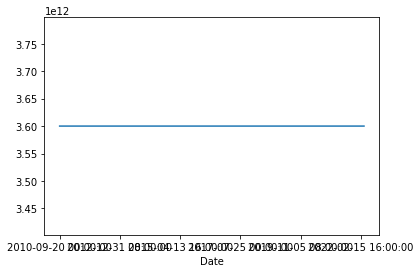

In [10]:
completeReturnsDf['Date'] = pd.to_datetime(completeReturnsDf.index.values)
times_gaps = completeReturnsDf.Date - completeReturnsDf.Date.shift(1)
times_gaps.plot()

Al obtener un valor constante, confirmamos que no existen brechas o repeticiones temporales en el conjunto de datos.

### LOG1P SOBRE LOS DATOS DE ALQUILERES Y DEVOLUCIONES
Hacer uso de una función logarítmica sobre los datos puede resultar efectivo posteriormente para el rendimiento de los modelos. Estos valores son reversible mediante la función expm1 de numpy.

In [14]:
for columnName in completeRentalsDf.columns:
    if columnName !='Date':
        completeRentalsDf[columnName] = np.log1p(completeRentalsDf[columnName])
        completeReturnsDf[columnName] = np.log1p(completeReturnsDf[columnName])

In [16]:
completeRentalsDf.to_csv('../data/completeData/rentals/completeRentalsDf_LOG1P.csv', index=False)
completeReturnsDf.to_csv('../data/completeData/returns/completeReturnsDf_LOG1P.csv', index=False)

In [17]:
completeRentalsDf_LOG1P = pd.read_csv('../data/completeData/rentals/completeRentalsDf_LOG1P.csv')
completeReturnsDf_LOG1P = pd.read_csv('../data/completeData/returns/completeReturnsDf_LOG1P.csv')

In [18]:
completeRentalsDf_LOG1P.tail(5)

,Date,0,31000,31001,31002,31003,31004,31005,31006,31007,...,32600,32601,32602,32603,32604,32605,32606,32607,32608,32609
101059,2022-03-31 19:00:00,2.772589,0.000000,0.0,0.000000,0.693147,0.0,0.693147,0.693147,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.693147
101060,2022-03-31 20:00:00,2.833213,0.693147,0.0,0.693147,0.000000,0.0,0.693147,0.693147,0.0,...,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.000000
101061,2022-03-31 21:00:00,0.693147,0.000000,0.0,0.000000,0.000000,0.0,0.693147,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
101062,2022-03-31 22:00:00,1.791759,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
101063,2022-03-31 23:00:00,1.791759,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


### NORMALIZACIÓN MIN-MAX SOBRE LOS DATOS DE ALQUILERES Y DEVOLUCIONES
Se guarda un conjunto de datos normalizados mediante MIN-MAX.

In [257]:
min_max_scaler = preprocessing.MinMaxScaler()
completeReturnsDf = pd.DataFrame(min_max_scaler.fit_transform(completeReturnsDf), columns=completeReturnsDf.columns, index=completeReturnsDf.index)
completeRentalsDf = pd.DataFrame(min_max_scaler.fit_transform(completeRentalsDf), columns=completeRentalsDf.columns, index=completeRentalsDf.index)

In [258]:
completeRentalsDf.to_csv('../data/completeData/rentals/completeRentalsDf_MINMAX.csv', index=False)
completeReturnsDf.to_csv('../data/completeData/returns/completeReturnsDf_MINMAX.csv', index=False)

In [259]:
completeRentalsDf_MINMAX = pd.read_csv('../data/completeData/rentals/completeRentalsDf_MINMAX.csv')
completeReturnsDf_MINMAX = pd.read_csv('../data/completeData/returns/completeReturnsDf_MINMAX.csv')

In [260]:
completeReturnsDf_MINMAX.tail(5)

,0,31000,31001,31002,31003,31004,31005,31006,31007,31008,...,32600,32601,32602,32603,32604,32605,32606,32607,32608,32609
101059,0.363636,0.000000,0.0,0.000000,0.166667,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00
101060,0.218182,0.083333,0.0,0.071429,0.000000,0.0,0.133333,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.25
101061,0.109091,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.083333,0.0,0.0,...,0.142857,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00
101062,0.236364,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00
101063,0.090909,0.083333,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00


In [261]:
completeReturnsDf_MINMAX.describe()

,0,31000,31001,31002,31003,31004,31005,31006,31007,31008,...,32600,32601,32602,32603,32604,32605,32606,32607,32608,32609
count,101064.000000,101064.000000,101064.000000,101064.000000,101064.000000,101064.000000,101064.000000,101064.000000,101064.000000,101064.000000,...,101064.000000,101064.000000,101064.000000,101064.000000,101064.000000,101064.000000,101064.000000,101064.000000,101064.000000,101064.000000
mean,0.028557,0.013435,0.022428,0.043052,0.038225,0.025377,0.037632,0.036032,0.042632,0.024579,...,0.001565,0.001018,0.002899,0.002430,0.001689,0.003248,0.003374,0.003758,0.001720,0.003389
std,0.090728,0.044201,0.058029,0.086688,0.079838,0.067383,0.075514,0.075534,0.081922,0.061959,...,0.018685,0.015115,0.029224,0.027009,0.019260,0.032040,0.028226,0.035135,0.020157,0.033266
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.071429,0.083333,0.000000,0.066667,0.083333,0.055556,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## METEOROLOGÍA

<img src="weather.png">

### RECOPILACIÓN DE LOS DATOS METEOROLÓGICOS

In [320]:
completeWeatherDf = pd.DataFrame()
for year in range(2010, 2023):
    df = pd.read_csv("../data/weather/" + str(year) + ".csv")
    completeWeatherDf = completeWeatherDf.append(df, ignore_index=True)
print("El conjunto de datos meteorológicos tiene {} filas y {} columnas".format(completeWeatherDf.shape[0], completeWeatherDf.shape[1]))

El conjunto de datos meteorológicos tiene 107351 filas y 24 columnas


In [321]:
completeWeatherDf = completeWeatherDf.loc[6287:len(completeWeatherDf)] #Eliminamos los primeros meses de 2010
completeWeatherDf.reset_index(drop=True, inplace=True)
print("El conjunto de datos meteorológicos tiene {} filas y {} columnas".format(completeWeatherDf.shape[0], completeWeatherDf.shape[1]))

El conjunto de datos meteorológicos tiene 101064 filas y 24 columnas


In [322]:
completeWeatherDf.tail(5)

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
101059,Washington,2022-03-31T19:00:00,20.7,20.7,14.5,67.78,0.0,0.0,rain,0.0,...,997.3,94.2,16.0,25.0,0.1,0.0,10.0,Overcast,cloudy,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,7..."
101060,Washington,2022-03-31T20:00:00,18.5,18.5,14.1,75.37,0.0,0.0,rain,0.0,...,997.1,92.7,16.0,5.0,0.0,0.0,10.0,Overcast,cloudy,"KDCA,72405013743,72403793728,E5309,KADW,KDAA,7..."
101061,Washington,2022-03-31T21:00:00,21.1,21.1,15.1,68.67,0.0,0.0,rain,0.0,...,996.8,94.4,16.0,0.0,NaN,0.0,10.0,Overcast,wind,"KDCA,72405013743,72403793728,KADW,KDAA,7459401..."
101062,Washington,2022-03-31T22:00:00,21.1,21.1,14.4,65.91,0.0,0.0,rain,0.0,...,998.1,92.4,16.0,0.0,NaN,0.0,10.0,Overcast,cloudy,"KDCA,72405013743,72403793728,KADW,KDAA,7459401..."
101063,Washington,2022-03-31T23:00:00,20.0,20.0,13.9,68.11,0.0,0.0,rain,0.0,...,997.7,81.3,16.0,0.0,NaN,0.0,10.0,Partially cloudy,partly-cloudy-night,"KDCA,72405013743,72403793728,KADW,KDAA,7459401..."


### COMPROBACIÓN DE DATOS METEOROLÓGICOS NULOS

In [323]:
completeWeatherDf.isnull().sum()

name                     0
datetime                 0
temp                     0
feelslike                0
dew                      0
humidity                 0
precip                 336
precipprob           99121
preciptype          100790
snow                 46297
snowdepth            46125
windgust             82081
windspeed                1
winddir                 96
sealevelpressure        32
cloudcover               0
visibility               0
solarradiation       84171
solarenergy          85074
uvindex                123
severerisk           99128
conditions               0
icon                     0
stations                 0
dtype: int64

El atributo 'windspeed' solo contiene un dato nulo, procedemos a arreglarlo haciendo una media entre la hora anterior y posterior.

In [324]:
for i, isnull in enumerate(completeWeatherDf['windspeed'].isnull()):
    if isnull==1: 
        nullIndex = i
print("{} es el indice en el que el atributo windspeed es nulo".format(nullIndex))

67879 es el indice en el que el atributo windspeed es nulo


In [325]:
print(completeWeatherDf.iloc[nullIndex-2:nullIndex+3].windspeed)

67877     5.4
67878     5.4
67879     NaN
67880     7.6
67881    11.2
Name: windspeed, dtype: float64


In [326]:
completeWeatherDf.loc[nullIndex,'windspeed'] = 6.5

Por otro lado, vamos a sustituir los 336 valores nulos del atributo 'precip' por el valor más frecuentado, en este caso, que no existan precipitaciones.

In [327]:
completeWeatherDf['precip'].value_counts()

0.00    90978
0.02      729
0.01      478
0.30      423
0.04      392
        ...  
8.10        1
6.44        1
4.77        1
4.88        1
6.93        1
Name: precip, Length: 851, dtype: int64

In [328]:
completeWeatherDf['precip'] = completeWeatherDf['precip'].fillna(0)

Se eliminan el resto de atributos que contienen nulos.

In [329]:
completeWeatherDf.drop(['name', 'precipprob', 'preciptype', 'snow', 'snowdepth', 'windgust', 'winddir', 'sealevelpressure', 'solarradiation', 'solarenergy', 'severerisk', 'icon', 'stations'], axis=1, inplace=True)

In [330]:
completeWeatherDf.head(5)

,datetime,temp,feelslike,dew,humidity,precip,windspeed,cloudcover,visibility,uvindex,conditions
0,2010-09-20T00:00:00,22.8,22.8,16.0,65.41,0.0,0.0,49.0,16.0,0.0,Partially cloudy
1,2010-09-20T01:00:00,22.0,22.0,16.0,69.12,0.0,0.0,88.9,16.0,0.0,Partially cloudy
2,2010-09-20T02:00:00,22.0,22.0,16.8,72.26,0.0,5.6,86.4,16.0,0.0,Partially cloudy
3,2010-09-20T03:00:00,21.0,21.0,16.8,77.01,0.0,7.7,49.0,16.0,0.0,Partially cloudy
4,2010-09-20T04:00:00,20.9,20.9,16.8,77.20,0.0,11.2,26.2,16.0,0.0,Partially cloudy


Se transforma la columna categórica 'conditions' a numérica generando las variables dummies.

In [331]:
completeWeatherDf['conditions'].unique()

array(['Partially cloudy', 'Clear', 'Overcast', 'Rain, Overcast',
       'Rain, Partially cloudy', 'Snow, Partially cloudy',
       'Snow, Overcast', 'Rain', 'Snow', 'Snow, Rain, Partially cloudy',
       'Freezing Drizzle/Freezing Rain, Overcast', 'Snow, Rain, Overcast',
       'Ice, Overcast'], dtype=object)

In [332]:
completeWeatherDf = pd.get_dummies(completeWeatherDf, columns=['conditions'])
completeWeatherDf.head(5)

,datetime,temp,feelslike,dew,humidity,precip,windspeed,cloudcover,visibility,uvindex,...,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy",conditions_Snow,"conditions_Snow, Overcast","conditions_Snow, Partially cloudy","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy"
0,2010-09-20T00:00:00,22.8,22.8,16.0,65.41,0.0,0.0,49.0,16.0,0.0,...,0,1,0,0,0,0,0,0,0,0
1,2010-09-20T01:00:00,22.0,22.0,16.0,69.12,0.0,0.0,88.9,16.0,0.0,...,0,1,0,0,0,0,0,0,0,0
2,2010-09-20T02:00:00,22.0,22.0,16.8,72.26,0.0,5.6,86.4,16.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,2010-09-20T03:00:00,21.0,21.0,16.8,77.01,0.0,7.7,49.0,16.0,0.0,...,0,1,0,0,0,0,0,0,0,0
4,2010-09-20T04:00:00,20.9,20.9,16.8,77.20,0.0,11.2,26.2,16.0,0.0,...,0,1,0,0,0,0,0,0,0,0


In [333]:
completeWeatherDf = completeWeatherDf.rename(columns={"datetime": "Date"})

### COMPROBACIÓN DEL ORDEN CRONOLÓGICO DE LOS DATOS METEOROLÓGICOS

<AxesSubplot:>

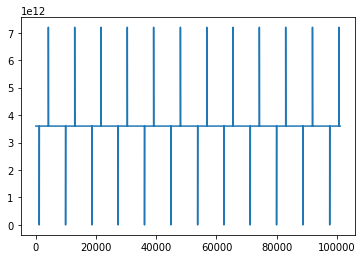

In [334]:
completeWeatherDf['Date'] = pd.to_datetime(completeWeatherDf['Date'])
times_gaps = completeWeatherDf.Date - completeWeatherDf.Date.shift(1)
times_gaps.plot()

Al no obtener una línea recta significa que no se sigue el orden cronológico, esto es debido a la repetición y salto de horas durante el cambio horario.

In [335]:
for i,isDuplicated in enumerate(completeWeatherDf.duplicated(subset=['Date'])):
    if isDuplicated:
        print("i --> {}, Anterior --> {}, Repetido --> {}, Siguiente --> {}".format(i,completeWeatherDf.iloc[i-1].Date,completeWeatherDf.iloc[i].Date,completeWeatherDf.iloc[i+1].Date))

i --> 1154, Anterior --> 2010-11-07 01:00:00, Repetido --> 2010-11-07 01:00:00, Siguiente --> 2010-11-07 02:00:00
i --> 9890, Anterior --> 2011-11-06 01:00:00, Repetido --> 2011-11-06 01:00:00, Siguiente --> 2011-11-06 02:00:00
i --> 18626, Anterior --> 2012-11-04 01:00:00, Repetido --> 2012-11-04 01:00:00, Siguiente --> 2012-11-04 02:00:00
i --> 27362, Anterior --> 2013-11-03 01:00:00, Repetido --> 2013-11-03 01:00:00, Siguiente --> 2013-11-03 02:00:00
i --> 36098, Anterior --> 2014-11-02 01:00:00, Repetido --> 2014-11-02 01:00:00, Siguiente --> 2014-11-02 02:00:00
i --> 44834, Anterior --> 2015-11-01 01:00:00, Repetido --> 2015-11-01 01:00:00, Siguiente --> 2015-11-01 02:00:00
i --> 53738, Anterior --> 2016-11-06 01:00:00, Repetido --> 2016-11-06 01:00:00, Siguiente --> 2016-11-06 02:00:00
i --> 62474, Anterior --> 2017-11-05 01:00:00, Repetido --> 2017-11-05 01:00:00, Siguiente --> 2017-11-05 02:00:00
i --> 71210, Anterior --> 2018-11-04 01:00:00, Repetido --> 2018-11-04 01:00:00, S

Observando estos resultados podemos comprobar que el cambio horario se ve presente en el conjunto de datos meteorologicos, por lo que lo adaptare al mismo formato que los datasets de alquileres y devoluciones.

In [336]:
# Establecemos correctamente las fechas
initDate, endDate = datetime(2010,9,20), datetime(2022,4,1)
for i,step in enumerate(np.arange(initDate, endDate, timedelta(minutes=60)).astype(datetime)):
    completeWeatherDf.at[i, 'Date'] = step

<AxesSubplot:>

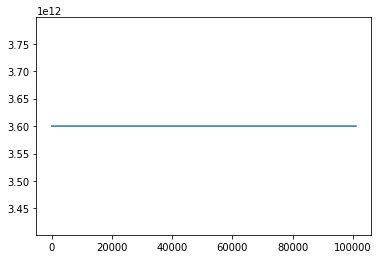

In [337]:
completeWeatherDf['Date'] = pd.to_datetime(completeWeatherDf['Date'])
times_gaps = completeWeatherDf.Date - completeWeatherDf.Date.shift(1)
times_gaps.plot()

### GUARDADO DEL DATAFRAME METEOROLOGICO COMPLETO

In [338]:
completeWeatherDf.to_csv('../data/completeData/weather/completeWeatherDf.csv', index=False)

### CARGA DEL DATAFRAME METEOROLOGICO COMPLETO

In [341]:
completeWeatherDf = pd.read_csv('../data/completeData/weather/completeWeatherDf.csv')